### Imports

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from matplotlib import image

import seaborn as sns
import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.io import imread
from skimage.color import rgb2gray

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



sns.set_palette('Paired')
sns.set_style("whitegrid")

### 1 - Data Extraction / Cleaning / Aggregation

This initial phase involves 

* Gathering data from data folders, refining it through cleaning processes, resizing and flattening
* Consolidating the images of each class into separate dataframes
* Combine the dataframes to form a single dataframe with their corresponding outputs (y) and then shuffle for randomness

In [2]:
dataset_folder = 'Dataset/'

class0_path = os.path.join(dataset_folder, 'Non_Demented/')
class1_path = os.path.join(dataset_folder, 'Very_Mild_Demented/')
class2_path = os.path.join(dataset_folder, 'Mild_Demented/')
class3_path = os.path.join(dataset_folder, 'Moderate_Demented/')

In [4]:
def resize_image(class_path, target_size=(60, 60)):
    class_images = []
    class_path = os.path.join(os.getcwd(), class_path)
    
    for filename in os.listdir(class_path):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_path, filename)
            image = cv2.imread(image_path)
            if image is not None:
                resized_image = cv2.resize(image, target_size)
                flattened_image = resized_image.flatten()
                class_images.append(flattened_image)
    
    return class_images
    



In [5]:
# Pass the path and get the resized images in an array

class0_images = resize_image(class0_path)
class1_images = resize_image(class1_path)
class2_images = resize_image(class2_path)
class3_images = resize_image(class3_path)


In [6]:
# Each row of the DataFrame represents a flattened and resized image from that class 

dfs = []
for index, images in enumerate([class0_images, class1_images, class2_images, class3_images]):
    class_df = pd.DataFrame(images)
    class_df['y'] = index
    dfs.append(class_df)

total_df = pd.concat(dfs,ignore_index=True)
total_df = total_df.sample(frac=1, random_state=30).reset_index(drop=True)

total_df.head()

,0,1,2,3,4,5,6,7,8,9,...,10791,10792,10793,10794,10795,10796,10797,10798,10799,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [10]:
# Check and fix null values in the dataset

null_count = total_df.isnull().values.sum()

print("Total number of null values:", null_count)

Total number of null values: 0


## 2 - Exploratory data analysis

Exploratory Data Analysis (EDA) involves examining and visualizing data to understand its characteristics, identify patterns, and detect anomalies. EDA helps gain insights into the data's structure and guides further analysis and decision-making.

Text(0.5, 1.0, 'Data - Class Distribution')

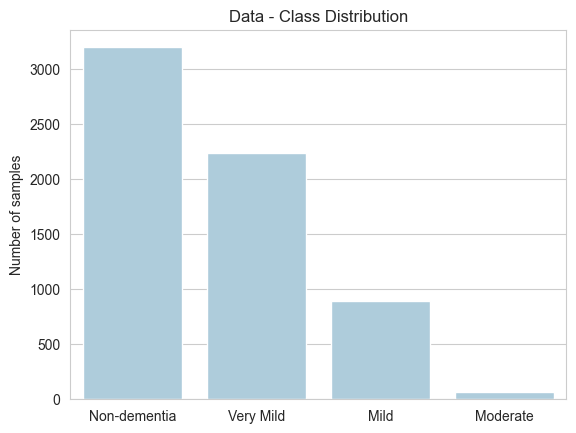

In [11]:
class_size= total_df['y'].value_counts()
class_labels = ['Non-dementia', 'Very Mild', 'Mild', 'Moderate']

sns.barplot(x = class_labels,y = class_size)
plt.ylabel('Number of samples')
plt.title('Data - Class Distribution')

We see a significant class imbalance in the dataset, especially for classes 2 and 3 (Mild Demented and Moderate Demented) compared to classes 0 and 1 (Non Demented and Very Mild Demented). This imbalance need to be addressed during model training to prevent bias towards the majority classes.Although we have classes with fewer samples, they are crucial for capturing the variability associated with dementia progression

## 3 - Data Split

In [12]:
# separate feature and output from total dataframe and then split the dataset as train/test.

X,y = total_df[total_df.columns[:-1]],total_df['y']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=100)



### 4 - Data Normalization - Feature scaling and dimensionality reduction

In [13]:
# StandardScaler is used to scale the features to the range [0,1]
# PCA is used to retain enough components to explain 90% of the variance in the data

# We create pipeline object and call the fit function to learn parameter values based on the estimators and dataset

data_pipe = Pipeline([('scaler', StandardScaler()), ('pca',PCA(n_components=0.9))])
data_pipe.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.9))])

In [14]:

# Transform the input based on the learned parameters from fit.

X_train = data_pipe.transform(X_train)
X_test = data_pipe.transform(X_test)



In [15]:
# Original - 60*60*3 = 10800 + 1(y)

print(f"Original Data has {total_df.shape[1]} features")
print(f"After PCA, Data has {X_train.shape[1]} features")

Original Data has 10801 features
After PCA, Data has 622 features


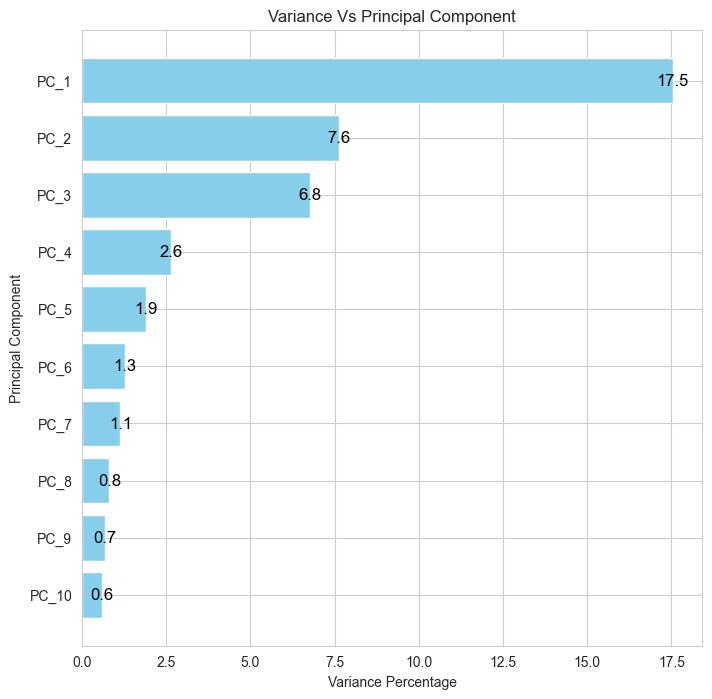

In [16]:
var_pc_top10 = [pc*100 for pc in data_pipe.named_steps['pca'].explained_variance_ratio_[:10]]

pc_labels = ['PC_'+str(pc+1) for pc in range(10)]

var_pc_top10.reverse()
pc_labels.reverse()

plt.figure(figsize=(8,8))
plt.barh(pc_labels, var_pc_top10, color='skyblue')

for index, pc in enumerate(var_pc_top10):
    plt.text(pc, index, format(pc, '.1f'), ha='center', va='center', size=12, color='black')

plt.title("Variance Vs Principal Component")

plt.xlabel('Variance Percentage')
plt.ylabel('Principal Component')

plt.show()


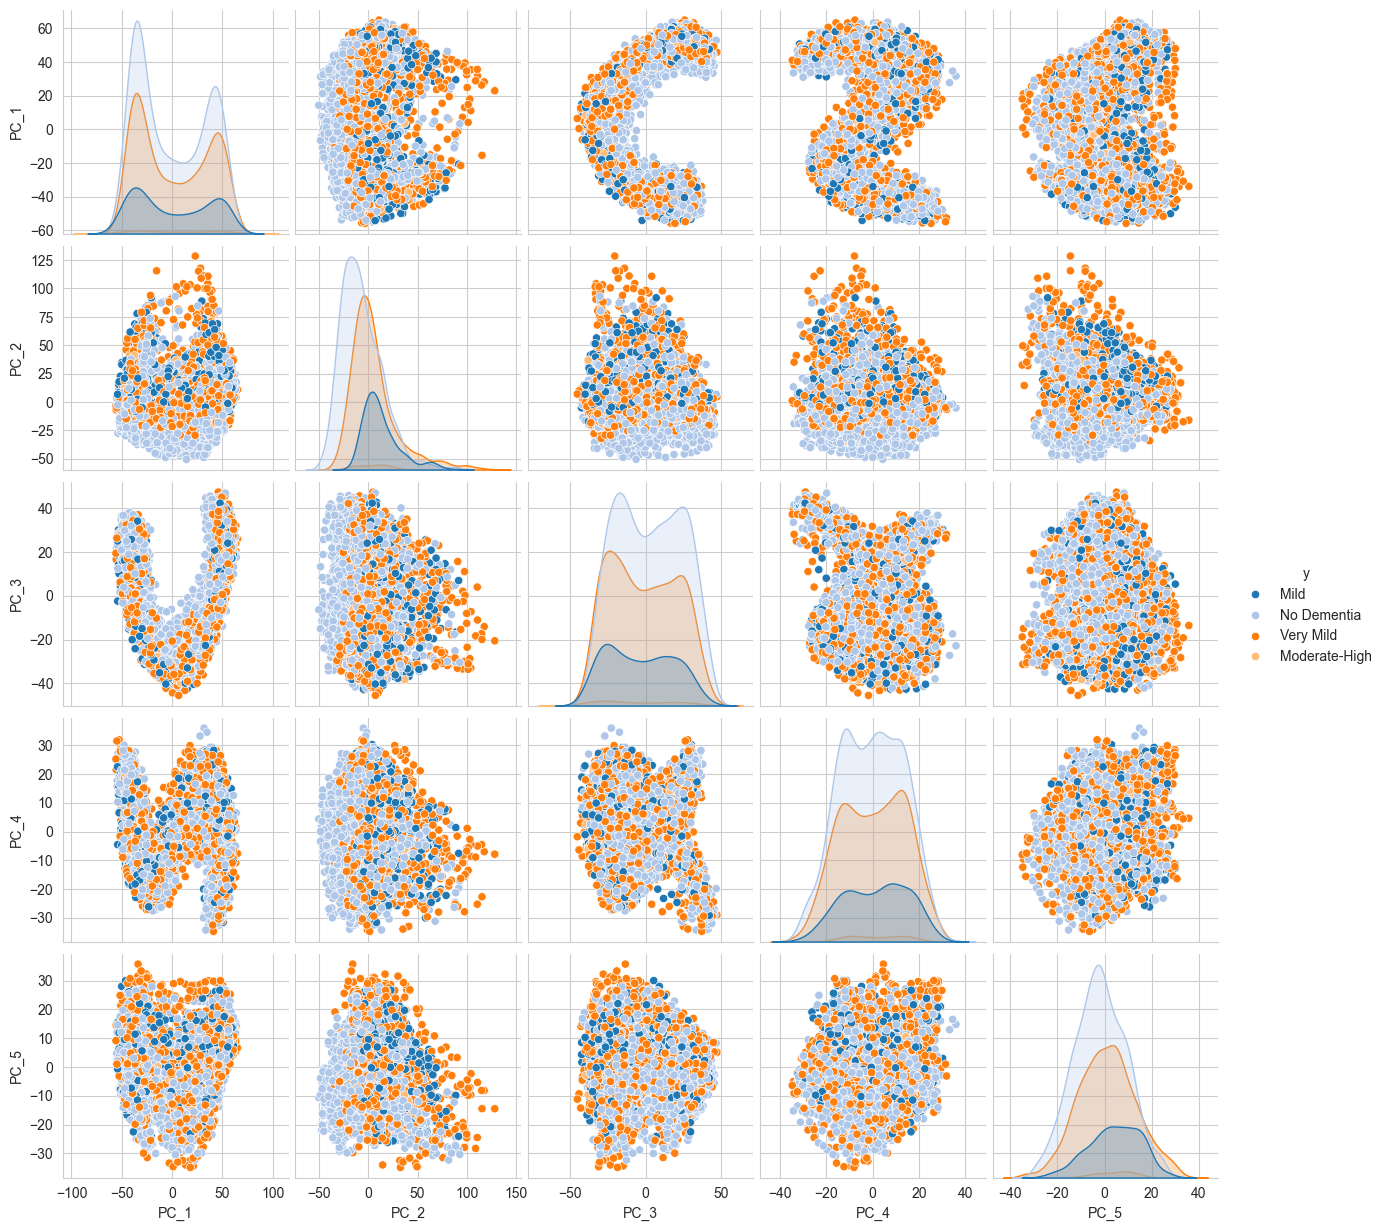

In [17]:
features = X_train[:,:5]
col_names = ['PC_'+str(x+1) for x in range(features.shape[1]) ]
scatter_df = pd.DataFrame(features,columns=col_names)
scatter_df['y'] = y_train.reset_index(drop=True)

label = {0:'No Dementia',1:'Very Mild', 2: 'Mild',3:'Moderate-High'}
scatter_df['y'] = scatter_df['y'].map(label)

sns.pairplot(scatter_df,hue="y",palette=sns.color_palette("tab20")[:len(label)],)



The diagonal plots show the distribution of different classes in a given principal component. The other plots show the relation between a pair of principal component and how they affect ouput.

From the above plot, it is very clear that , the data is not separable in lower dimensions, as we can see in scatter plots. Hence it is not easy to find a linearly separable boundary.

## Step 5 : Data Modelling

In [18]:
#Base function for models

def train_model(model, search_grid, X_train, y_train):
    # Define cross-validation strategy
    cv = KFold(n_splits=10)
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=search_grid, 
        n_jobs=-1, 
        cv=cv, 
        scoring='accuracy', 
        error_score=0
    )
    grid_result = grid_search.fit(X_train, y_train)
    
    return grid_result


def scatter_plots(score_array, title):
    sns.set_palette('CMRmap')
    
    # Calculate maximum test scores from cross-validation results
    lr_scores = [max(score_array.cv_results_['split'+str(i)+'_test_score']) for i in range(0, 10)]
    
    # Plot line plot
    sns.lineplot(x=range(1, 11), y=lr_scores,color='green')
    
    # Plot scatter plot
    for i, j in enumerate(lr_scores):
        if j == max(lr_scores):
            plt.scatter(i+1, j, c='blue', marker='o', s=200)
            plt.annotate(format(j, '.3f'), (i+1, j), size=15)
    
    plt.xlabel('Cross Validation Steps')
    plt.ylabel('Model Accuracy')
    plt.title(f'Cross Validation Accuracies for {title}', size=15)
    plt.show()

def cf_plot(score_array, title):
    plt.figure(figsize=(9, 7))
    
    # Calculate confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred=score_array.predict(X_test))
    
    # Plot confusion matrix heatmap
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Greens', annot_kws={"size": 15})
    
    plt.xlabel('Predicted Label', size=15)
    plt.ylabel('Actual Label', size=15)
    plt.title(f'Confusion Matrix for {title}', size=15)
    plt.show()    
    
    # Print classification report
    print(classification_report(y_test, y_pred=score_array.predict(X_test)))

    report = classification_report(y_test, y_pred=score_array.predict(X_test))
    return report


### Step 5.1 Logistic Regression

In [16]:
lr_model = LogisticRegression(max_iter=100)

# Define the search grid
solvers = ['newton-cg']
penalty = ['l2']
c_values = [1.0, 0.1, 0.01, 0.001]
lr_search_grid = dict(solver=solvers, penalty=penalty, C=c_values)

# Train the model using grid search
lr_grid_result = train_model(lr_model, lr_search_grid,X_train, y_train)

# Print the results
print(lr_grid_result.cv_results_)


{'mean_fit_time': array([52.02338028, 34.85012109, 15.77316866, 10.65279715]), 'std_fit_time': array([6.31534606, 9.11080116, 1.84758366, 0.92699071]), 'mean_score_time': array([0.00379035, 0.00643315, 0.00306971, 0.00616026]), 'std_score_time': array([0.00339805, 0.00636463, 0.00432874, 0.00494389]), 'param_C': masked_array(data=[1.0, 0.1, 0.01, 0.001],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_penalty': masked_array(data=['l2', 'l2', 'l2', 'l2'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_solver': masked_array(data=['newton-cg', 'newton-cg', 'newton-cg', 'newton-cg'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}, {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}, {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}, {'C': 0.001, 'penalty': 'l2', 's

In [36]:
y_test.shape

(1280,)

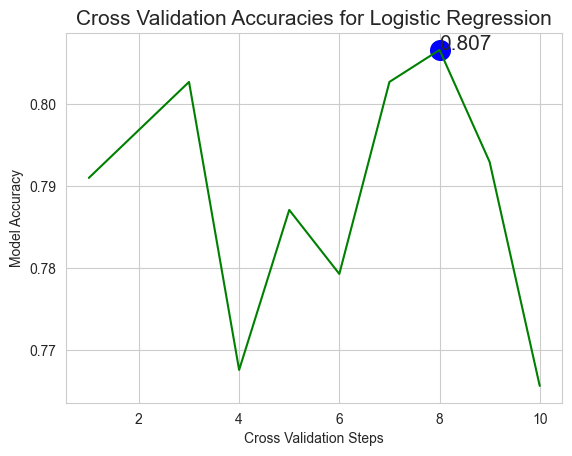

In [18]:
scatter_plots(lr_grid_result,'Logistic Regression')

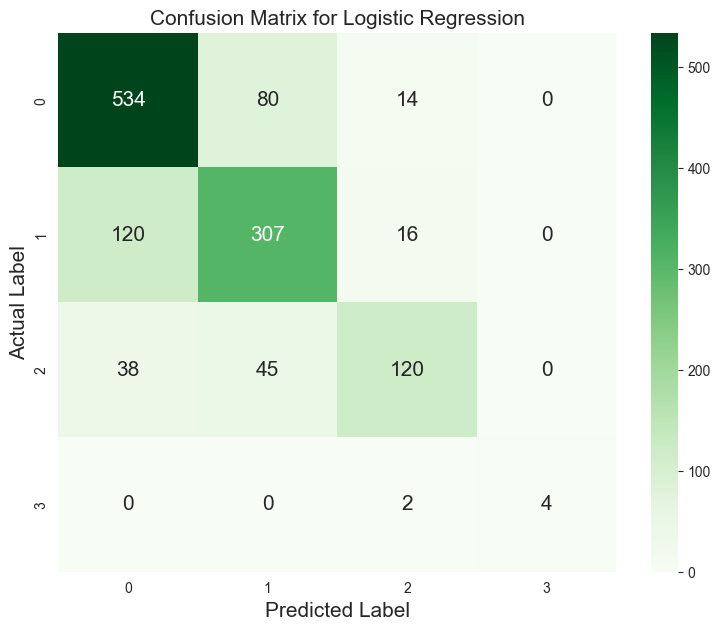

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       628
           1       0.71      0.69      0.70       443
           2       0.79      0.59      0.68       203
           3       1.00      0.67      0.80         6

    accuracy                           0.75      1280
   macro avg       0.82      0.70      0.75      1280
weighted avg       0.75      0.75      0.75      1280



In [40]:
lr_report = cf_plot(lr_grid_result,'Logistic Regression')

In [41]:
print(lr_report[])

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       628
           1       0.71      0.69      0.70       443
           2       0.79      0.59      0.68       203
           3       1.00      0.67      0.80         6

    accuracy                           0.75      1280
   macro avg       0.82      0.70      0.75      1280
weighted avg       0.75      0.75      0.75      1280



In [20]:
best_params = lr_grid_result.best_params_
print("Final parameter combination chosen:", best_params)


Final parameter combination chosen: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}


### Step 5.2 : SVM

In [21]:
svm_model = SVC()

# Define the search parameters
c_values = [0.5, 1, 2, 5, 10]
kernel = ['rbf', 'poly']

search_parameters = {'C': c_values, 'kernel': kernel}

# Train the model using grid search
svm_grid_result = train_model(svm_model, search_parameters,X_train, y_train)

# Print the best parameters
print(svm_grid_result.best_params_)


{'C': 5, 'kernel': 'rbf'}


In [23]:
svm_grid_result.score(X_test,y_test)

0.984375

In [24]:
svm_grid_result.best_params_

{'C': 5, 'kernel': 'rbf'}

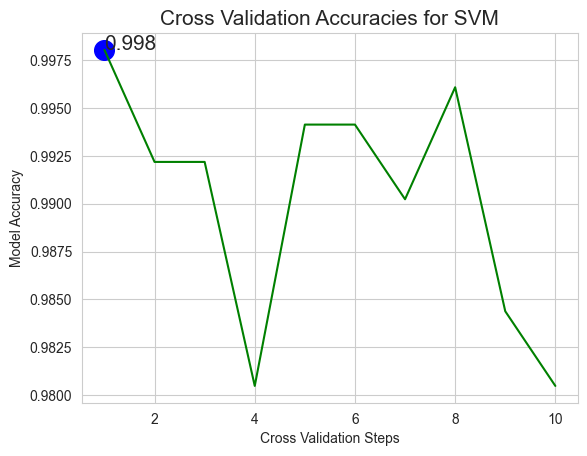

In [25]:
scatter_plots(svm_grid_result,'SVM')

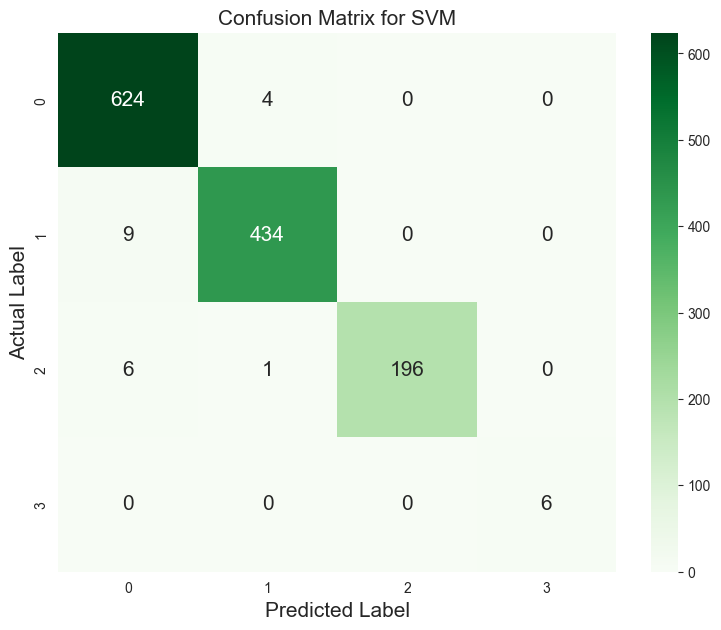

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       628
           1       0.99      0.98      0.98       443
           2       1.00      0.97      0.98       203
           3       1.00      1.00      1.00         6

    accuracy                           0.98      1280
   macro avg       0.99      0.98      0.99      1280
weighted avg       0.98      0.98      0.98      1280



In [26]:
cf_plot(svm_grid_result,'SVM')

### 5.3 Random Forest

In [34]:

random_forest= RandomForestClassifier()
no_of_trees = [10, 100, 500,1000]
no_of_features = ['sqrt', 'log2']

search_grid = dict(n_estimators=no_of_trees,max_features=no_of_features)
random_forest_result  = train_model(random_forest,search_grid,X_train,y_train)

random_forest_result.best_params_

{'max_features': 'sqrt', 'n_estimators': 1000}

num_splits: 10
Length of no_of_trees: 4
Length of val_scores: 4


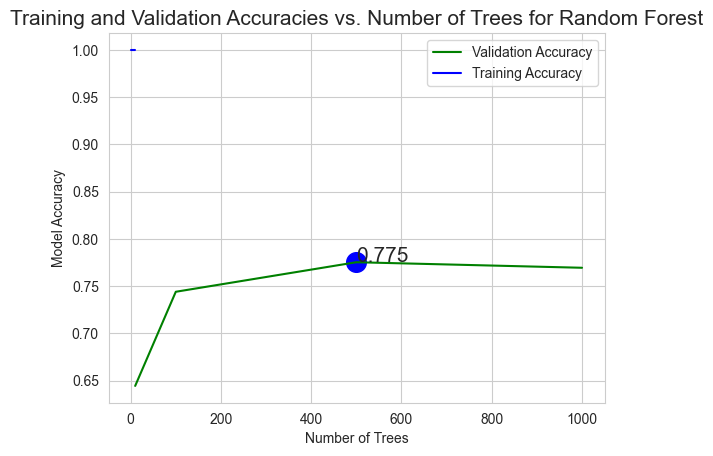

In [57]:
scatter_plots(random_forest_result ,'Random Forest')

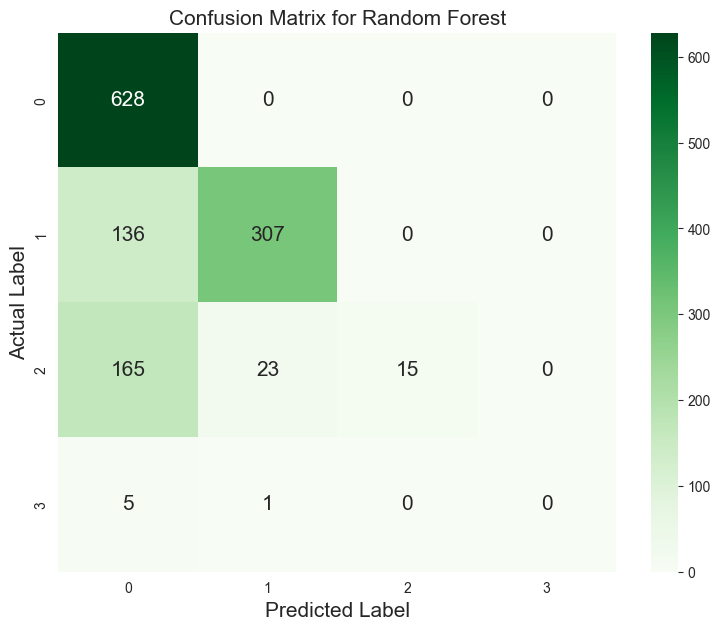

              precision    recall  f1-score   support

           0       0.67      1.00      0.80       628
           1       0.93      0.69      0.79       443
           2       1.00      0.07      0.14       203
           3       0.00      0.00      0.00         6

    accuracy                           0.74      1280
   macro avg       0.65      0.44      0.43      1280
weighted avg       0.81      0.74      0.69      1280



C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.

In [29]:
cf_plot(random_forest_result ,'Random Forest')